# An implementation of Federated Learning in a Smart Home environment
## Master's Thesis
## Author: Daniel Bustillo Mac Lean
1st Examiner: Prof. Dr. Stefan Lessmann

2nd Examiner: PD Dr. Benjamin Fabian

Supervisor: Dr. Alona Zharova

Date: 13.06.2022

# Smart * Home 

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import flwr as fl
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [108]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

In [107]:
plt.rcParams["figure.figsize"] = (25,15)
plt.rcParams.update({'font.size': 22})

In [109]:
# Set the right path for the files
path="/Users/daniel.bustillo/Documents/thesis"

In [ ]:
os.chdir(path)

In [110]:
homes= pd.read_csv("homes.csv", infer_datetime_format=True, index_col=0, parse_dates=True)

## EDA and plots

In [12]:
homes1 = homes.copy()


In [18]:
homes1['hour'] = homes1.index.hour
homes1['weekday'] = homes1.index.weekday
avg= homes1.groupby(['hour','weekday']).mean()['total_f']
avg = avg.reset_index()
avg_pivot= avg.pivot("hour","weekday","total_f")
avg_pivot.columns=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

Text(0.5, 1.0, 'Average weekly electricity consumption in House F (in kWh)')

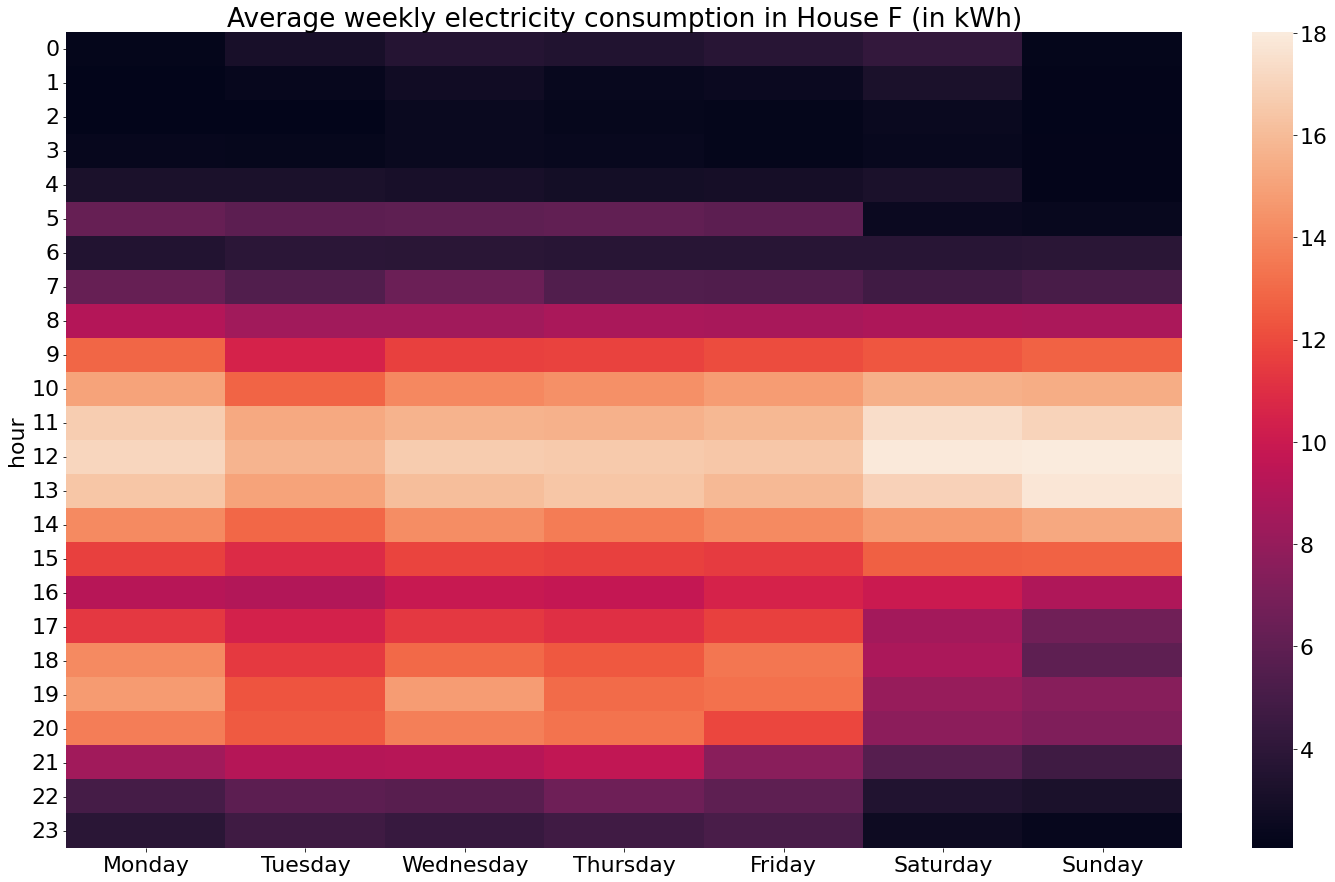

In [19]:
g=sns.heatmap(avg_pivot)
locs, labels = plt.yticks()
plt.setp(labels, rotation=0)
plt.title("Average weekly electricity consumption in House F (in kWh)")

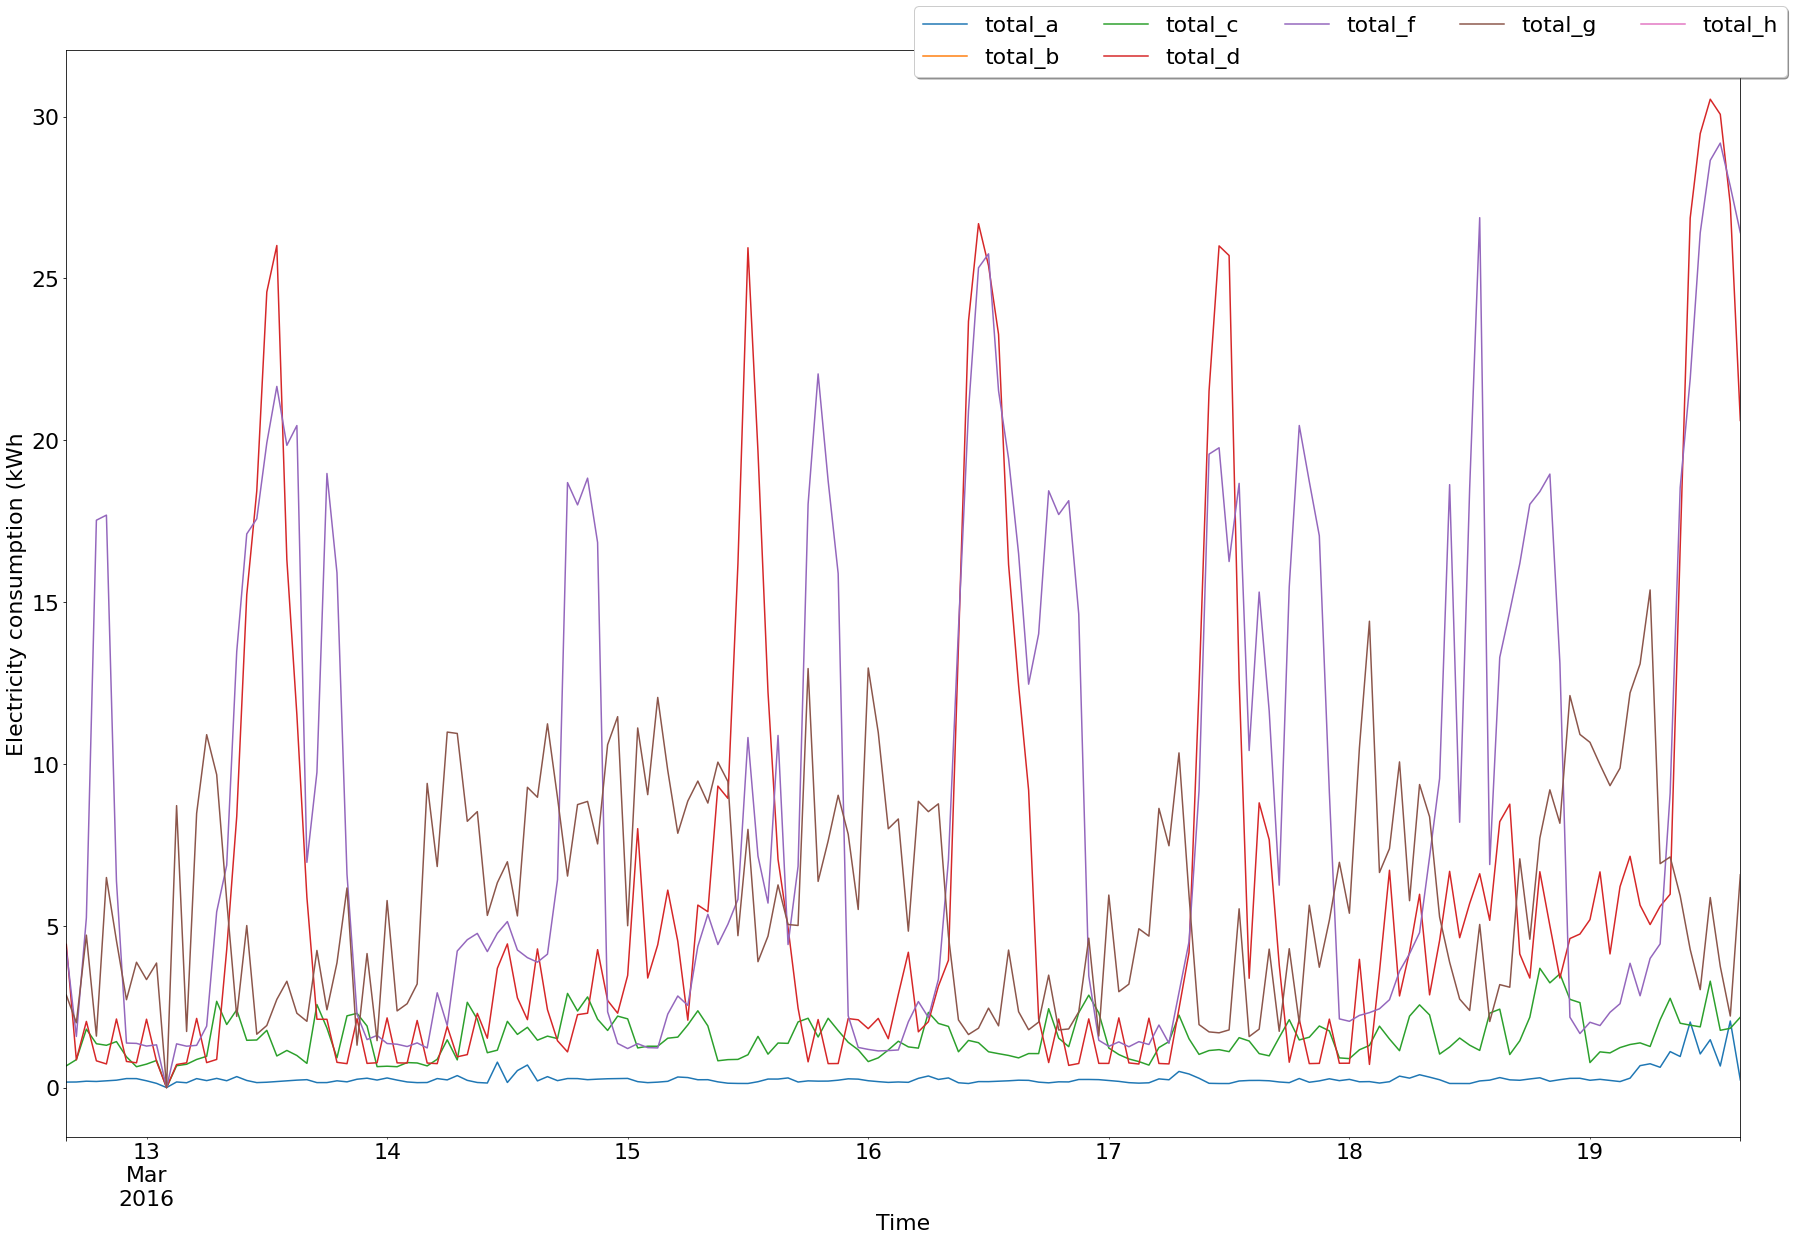

In [164]:
homes.iloc[28000:28168].plot(figsize=(30,20), xlabel="Time", ylabel= "Electricity consumption (kWh")
plt.legend(loc='upper left', bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=True)
plt.show()

## Some functions

In [111]:
def create_dataset(time_series, timesteps):
    dataX, dataY = [], []
    
    for i in range(0, len(time_series)-timesteps ): # The last 
        x = time_series[i:(i+timesteps)]    ####### Remember Python's x[a, b-1]
        dataX.append(x)
        y = time_series[(i+timesteps)]      ##### Remember Python's x[b]
        dataY.append(y)
           
    return np.array(dataX), np.array(dataY) #dont forget to convert to np.arrays

In [112]:

def rmse(y_true, y_score):
    error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
    return error

def mape(y_true,y_score):
    error = mean_absolute_percentage_error(y_true, y_score)
    return error

In [296]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [181]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = [],[]
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('home_%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('home_%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('home_%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
def weight_scalling_factor(clients_trn_data, client_name):
    #client_names = list(homes.columns())
    #get the bs
    #bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clients
    global_count = sum([len(clients_trn_data[client_name].dropna()) for client_name in client_names])
    # get the total number of data points held by a client
    local_count = len(clients_trn_data[client_name].dropna())
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


    
def test_model(X_test, Y_test,  model, comm_round, home):
    preds = model.predict(X_test)
    loss = rmse(Y_test, preds)
    scaled_preds= scaler.inverse_transform(preds)
    scaled_loss = rmse(scaler.inverse_transform(Y_test), scaled_preds)
    print('comm_round: {} |loss_in_{}: {} | scaled_loss_in_{}: {}'.format(comm_round,home,loss, home, scaled_loss))
    return loss, scaled_loss, preds, scaled_preds

In [ ]:
def prepare_task(home: pd.Series, train_size= 0.9, timesteps= 1):
    """function that wraps all the processes of data preparation and model configuration"""
     #Drop nan values
    home= home.dropna()

    # train, test split
    # split into train and test sets
    values = home.values
    values= values.reshape(len(values),1)
    train, test = train_test_split(values, train_size=train_size, shuffle=False)

    # Scaling the data to the interval [0,1]
    scaler = MinMaxScaler(feature_range=(0, 1))

    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    
    
    # The LSTM input layer must be 3D
    # Create the dataset with rolling window for the training set and test set
    X_train, y_train  = create_dataset(train, timesteps)  # lookback
    X_test, y_test    = create_dataset(test, timesteps)
    #print(X_train.shape)

    return X_train, y_train, X_test, y_test, scaler

## Multivariate Time Series forecasting with LSTMS

In [179]:
example = homes

In [180]:
values = example.values
values = values.astype('float32')
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values)

In [182]:
# frame as supervised learning
reframed = series_to_supervised(values, 1, 1, dropnan=False)

In [183]:
multi_train ={}
multi_test ={}

multi_rmse_train = {}
multi_rmse_test = {}

multi_mape_train ={}
multi_mape_test = {}

In [184]:
def train_multi_model(df, train_size = 0.9, neurons = 256, epochs=50, batch_size=64):
    '''function that takes a cleaned version of the modified dataframe, transforms the data into 
    [Samples, timesteps, features] , splits it into training and testing data, and trains a model on the 
    fitted data to then predict the test data and calculate the root mean square'''
    #Drop nan values
    df= df.dropna()
    # train, test split
    # split into train and test sets
    values = df.values
    train, test = train_test_split(values, train_size=train_size, shuffle=False)

    # Scaling the data to the interval [0,1]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    
    
    X_train, y_train = train[:, :-1], train[:, -1]
    X_test, y_test =test[:, :-1], test[:,-1]
    
    # reshape input to be 3D [samples, timesteps, features]

    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


    # design network
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(X_train.shape[1],X_train.shape[2]),return_sequences=True))
    model.add(LSTM(neurons, return_sequences=False))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam', metrics=["mean_squared_error", "mean_absolute_error"])


    # fit network
    history2 = model.fit(X_train, y_train,epochs=epochs, batch_size=batch_size, verbose=2, shuffle=False)


    #Predict on both sets
    yhat_test= model.predict(X_test)
    yhat_train = model.predict(X_train)

    #Reshape them to fit the right format to inverse_transform
    X_train = X_train.reshape((X_train.shape[0],X_train.shape[2]))
    X_test = X_test.reshape((X_test.shape[0],X_test.shape[2]))

    inv_yhat_test= np.concatenate((X_test, yhat_test), axis=1)
    inv_yhat_train=np.concatenate((X_train, yhat_train), axis=1)

    inv_yhat_test = scaler.inverse_transform(inv_yhat_test)
    inv_yhat_train = scaler.inverse_transform(inv_yhat_train)

    multi_test_pred= inv_yhat_test[:,-1]
    multi_train_pred = inv_yhat_train[:,-1]

    #Invert scaling for actual 
    y_test = y_test.reshape(len(y_test),1)
    y_train = y_train.reshape(len(y_train),1)

    inv_y_test= np.concatenate((X_test, y_test), axis=1)
    inv_y_train= np.concatenate((X_train, y_train), axis=1)

    inv_y_test = scaler.inverse_transform(inv_y_test)
    inv_y_train = scaler.inverse_transform(inv_y_train)

    multi_test_true= inv_y_test[:,-1]
    multi_train_true = inv_y_train[:,-1]


    multi_rmse_test= rmse(inv_y_test, inv_yhat_test)
    multi_rmse_train = rmse(inv_y_train, inv_yhat_train)

    multi_mape_test= mape(inv_y_test, inv_yhat_test)
    multi_mape_train = mape(inv_y_train, inv_yhat_train)

    #multi_test = pd.DataFrame(multi_test)


    #multi_test.plot()

    return multi_train_pred, multi_test_pred,multi_train_true, multi_test_true,multi_rmse_train,multi_rmse_test, multi_mape_train, multi_mape_test


In [185]:
home_a = reframed.iloc[:,[0,2,3,4,5,7]]
home_b = reframed.iloc[:,[1,2,4,8]]
home_c = reframed.iloc[:,[1,2,4,9]]
home_d = reframed.iloc[:,[0,2,3,4,5,10]]
home_f = reframed.iloc[:,[1,2,4,11]]
home_g= reframed.iloc[:,[0,2,3,4,5,6,12]]
home_h = reframed.iloc[:,[0,2,3,4,5,6,13]]
trainhomes= [home_a, home_b, home_c,home_d, home_f, home_g, home_h]

In [186]:
housenames =["home_a", "home_b","home_c","home_d","home_f","home_g","home_h"]
multihomes= dict(zip(housenames,trainhomes))


In [187]:
for key, value in multihomes.items():
    multi_train_pred, multi_test_pred,multi_train_true, multi_test_true,multi_error_train,multi_error_test, multi_mape1_train, multi_mape1_test = train_multi_model(value, epochs=50)
    multi_train[f"true_{key}"] = multi_train_true
    multi_train[f"multi_{key}"] = multi_train_pred

    multi_test[f"true_{key}"] = multi_test_true
    multi_test[f"multi_{key}"] = multi_test_pred

    multi_rmse_test[f"multi_{key}"] = multi_error_test
    multi_rmse_train[f"multi_{key}"] = multi_error_train

    multi_mape_train[f"multi_{key}"] = multi_mape1_train
    multi_mape_test[f"multi_{key}"] = multi_mape1_test

(12654, 1, 5) (12654,) (1407, 1, 5) (1407,)
Epoch 1/50
198/198 - 7s - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0560 - 7s/epoch - 33ms/step
Epoch 2/50
198/198 - 2s - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0460 - 2s/epoch - 9ms/step
Epoch 3/50
198/198 - 2s - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0455 - 2s/epoch - 11ms/step
Epoch 4/50
198/198 - 2s - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0451 - 2s/epoch - 11ms/step
Epoch 5/50
198/198 - 2s - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0447 - 2s/epoch - 11ms/step
Epoch 6/50
198/198 - 2s - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0444 - 2s/epoch - 11ms/step
Epoch 7/50
198/198 - 2s - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0441 - 2s/epoch - 10ms/step
Epoch 8/50
198/198 - 2s - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0438 - 2s/epoch -

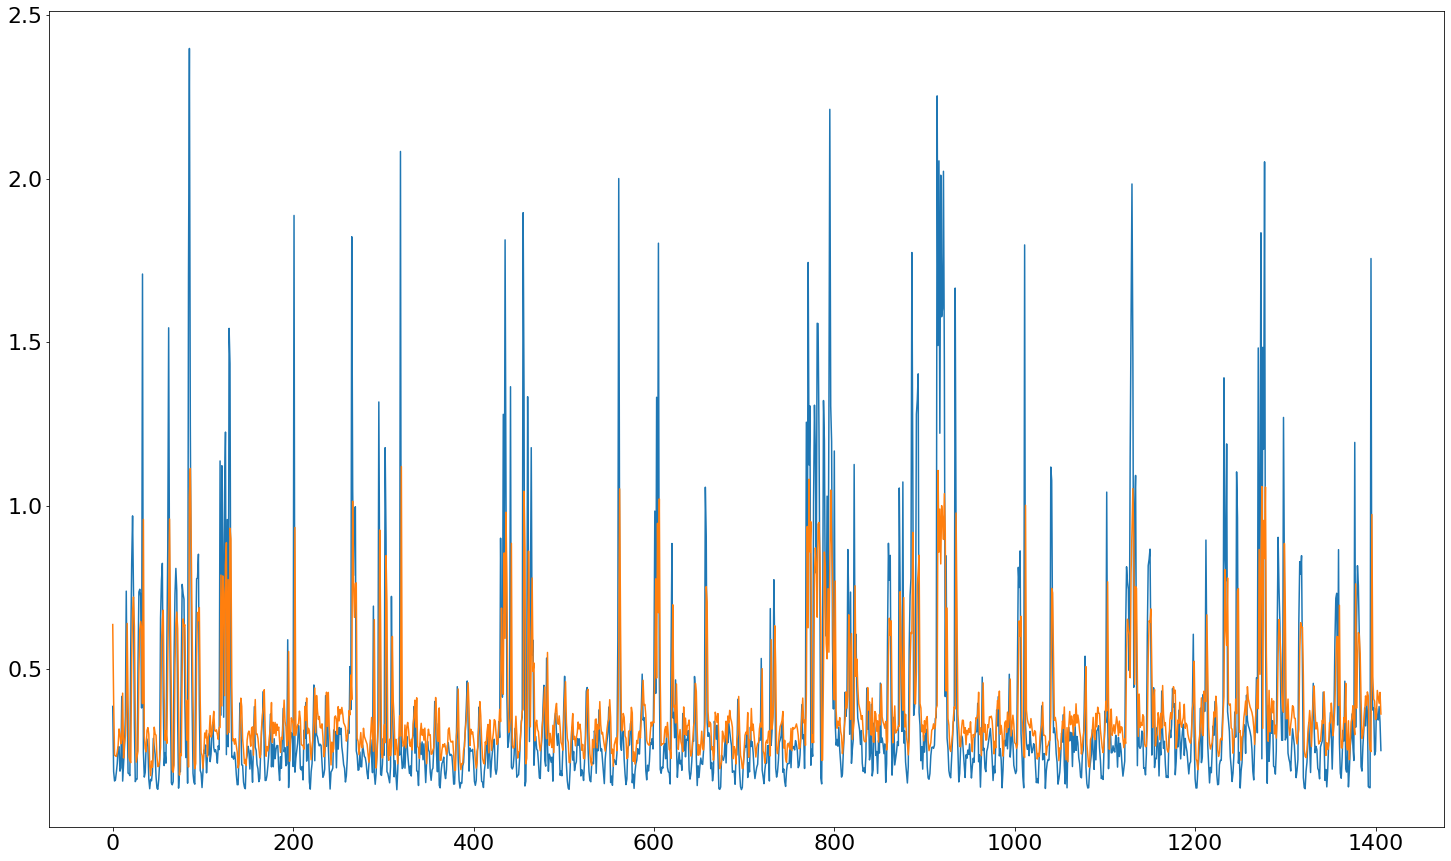

In [122]:
plt.plot(multi_test['true_home_a'])
plt.plot(multi_test['multi_home_a'])

## Simple LSTM

In [301]:
def run_model(home: pd.Series, train_size=0.8, timesteps= 1, epochs=50, batch_size= 64, neurons=128, plot=False):
    """function that wraps all the processes of data preparation and model configuration"""
     #Drop nan values
    home= home.dropna()

    # train, test split
    # split into train and test sets
    values = home.values
    values= values.reshape(len(values),1)
    train, test = train_test_split(values, train_size=train_size, shuffle=False)

    # Scaling the data to the interval [0,1]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    
    
    # The LSTM input layer must be 3D
    # Create the dataset with rolling window for the training set and test set
    X_train, y_train  = create_dataset(train, timesteps)  # lookback
    X_test, y_test    = create_dataset(test, timesteps)
    print(X_train.shape)

    #Define the model
    model = Sequential()
    model.add(LSTM(neurons))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])

    #Fit the data
    history= model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1, shuffle=False,
    callbacks=[callback])
    


    def rmse(y_true, y_score):
        error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
        return error

    pred_train[f"true_{home.name}"] = scaler.inverse_transform(y_train).flatten()  # store as 1d array
    pred_test[f"true_{home.name}"]  = scaler.inverse_transform(y_test).flatten() 

    pred_train[f"simple_lstm_{home.name}"] = scaler.inverse_transform(
                                model.predict(X_train,verbose=0)).flatten()

    pred_test[f'simple_lstm_{home.name}'] = scaler.inverse_transform(model.predict(X_test)).flatten()

    if plot==True:
    # plot history
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
        plt.show()

        #plot the predictions
        plt.plot(pred_test[f'true_{home.name}'])
        plt.plot(pred_test[f'simple_lstm_{home.name}'])
        plt.show()
    else:
        pass


    rmse_test[f'single_{home.name}'] = rmse(pred_test[f'true_{home.name}'], pred_test[f'simple_lstm_{home.name}'])
    rmse_train[f'single_{home.name}'] = rmse(pred_train[f'true_{home.name}'], pred_train[f'simple_lstm_{home.name}'])

    mape_test[f'single_{home.name}'] = mape(pred_test[f'true_{home.name}'], pred_test[f'simple_lstm_{home.name}'])
    mape_train[f'single_{home.name}'] = mape(pred_train[f'true_{home.name}'], pred_train[f'simple_lstm_{home.name}'])

  
    print(f"The RMSE in the train set is: {rmse_train[f'single_{home.name}']}")
    print(f"The RMSE in the test set is: {rmse_test[f'single_{home.name}']}")




    


    

### Convolutional LSTM

In [302]:
def run_conv_model(home: pd.Series, train_size, timesteps= 1, n_features=1, epochs=50, batch_size= 64, plot=False):
    """function that wraps all the processes of data preparation and model configuration"""
     #Drop nan values
    home= home.dropna()

    # train, test split
    # split into train and test sets
    values = home.values
    values= values.reshape(len(values),1)
    train, test = train_test_split(values, train_size=train_size, shuffle=False)

    # Scaling the data to the interval [0,1]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    
    
    # The LSTM input layer must be 3D
    # Create the dataset with rolling window for the training set and test set
    X_train, y_train  = create_dataset(train, timesteps)  # lookback
    X_test, y_test    = create_dataset(test, timesteps)
    print(X_train.shape)

   

    conv = Sequential()
    conv.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(timesteps, n_features)))
    conv.add(MaxPooling1D(pool_size=1))
    conv.add(Flatten())
    conv.add(Dense(50, activation='relu'))
    conv.add(Dense(1))
    conv.compile(optimizer='adam', loss='mse')

    #Fit the data
    history= conv.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1, shuffle=False,
    callbacks=[callback])
    

    pred_train[f"true_{home.name}"] = scaler.inverse_transform(y_train).flatten()  # store as 1d array
    pred_test[f"true_{home.name}"]  = scaler.inverse_transform(y_test).flatten() 

    pred_train[f"convlstm_{home.name}"] = scaler.inverse_transform(
                                conv.predict(X_train,verbose=0)).flatten()

    pred_test[f'convlstm_{home.name}'] = scaler.inverse_transform(conv.predict(X_test)).flatten()

    if plot==True:
        # plot history
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
        plt.show()

        #plot the predictions
        plt.plot(pred_test[f'true_{home.name}'])
        plt.plot(pred_test[f'convlstm_{home.name}'])
        plt.show()
    else:
        pass


    rmse_test[f'conv_{home.name}'] = rmse(pred_test[f'true_{home.name}'], pred_test[f'convlstm_{home.name}'])
    rmse_train[f'conv_{home.name}'] = rmse(pred_train[f'true_{home.name}'], pred_train[f'convlstm_{home.name}'])
    
    mape_test[f'conv_{home.name}'] = mape(pred_test[f'true_{home.name}'], pred_test[f'convlstm_{home.name}'])
    mape_train[f'conv_{home.name}'] = mape(pred_train[f'true_{home.name}'], pred_train[f'convlstm_{home.name}'])

  
    print(f"The RMSE in the train set is: {rmse_train[f'conv_{home.name}']}")
    print(f"The RMSE in the test set is: {rmse_test[f'conv_{home.name}']}")



    


    

In [300]:
timesteps =1
n_features=1 

# Federated approach

In [286]:
class SimpleLSTM:
    @staticmethod
    def build(neurons, timesteps =1, n_features=1):
        model = Sequential()
        model.add(LSTM(neurons, input_shape =(timesteps,n_features)))
        model.add(Dense(1))
        model.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])
        
        
        return model

In [290]:
comms_round = 30
    
#create optimizer
lr = 0.01 
loss='mean_squared_error'
metrics = ['mse']
optimizer = SGD(learning_rate=lr, 
                decay=lr / comms_round, 
                momentum=0.9
               ) 



In [291]:
client_names = homes.columns


In [292]:
#initialize global model
smlp_global = SimpleLSTM()
global_model = smlp_global.build(256, 1, 1)
        


In [ ]:
pred_train = {}
pred_test = {}

rmse_train={}
rmse_test = {}

mape_train = {}
mape_test = {}

In [294]:
#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #loop through each client and create new local model
    for home in homes:
        smlp_local = SimpleLSTM()
        local_model = smlp_local.build(256)
        local_model.compile(loss=loss, 
                        optimizer="adam", #Trying out adam
                        metrics=metrics)
        
        
    #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        #scaler = MinMaxScaler(feature_range=(0, 1))
        X_train, y_train, X_test, y_test, scaler= prepare_task(homes[home])


        local_model.fit(X_train, y_train, epochs=5, verbose=0, batch_size=64)
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(homes, home)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)

        local_loss = test_model(X_test, y_test, global_model, comm_round, home)


        pred_train[f"true_{home}"] = scaler.inverse_transform(y_train).flatten()  # store as 1d array
        pred_test[f"true_{home}"]  = scaler.inverse_transform(y_test).flatten() 

        pred_train[f"fed_{home}"] = scaler.inverse_transform(
                                    local_model.predict(X_train)).flatten()

        pred_test[f"fed_{home}"] = scaler.inverse_transform(local_model.predict(X_test)).flatten()

        rmse_test[f'fed_{home}'] = rmse(pred_test[f'true_{home}'], pred_test[f'fed_{home}'])
        rmse_train[f'fed_{home}'] = rmse(pred_train[f'true_{home}'], pred_train[f'fed_{home}'])
        
        mape_train[f'fed_{home}'] = mape(pred_train[f'true_{home}'], pred_train[f'fed_{home}'])
        mape_test[f'fed_{home}'] = mape(pred_test[f'true_{home}'], pred_test[f'fed_{home}'])
        K.clear_session()
    
            
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)
  

comm_round: 0 |loss_in_total_a: 0.14574328336904033 | scaled_loss_in_total_a: 0.4672669336006047
comm_round: 0 |loss_in_total_b: 0.11339432169000546 | scaled_loss_in_total_b: 2.1181678789755374
comm_round: 0 |loss_in_total_c: 0.1948848526430442 | scaled_loss_in_total_c: 2.1891838829772228
comm_round: 0 |loss_in_total_d: 0.2111985746441581 | scaled_loss_in_total_d: 6.920345748566314
comm_round: 0 |loss_in_total_f: 0.08334039390107302 | scaled_loss_in_total_f: 12.087198930572997
comm_round: 0 |loss_in_total_g: 0.23552164223354968 | scaled_loss_in_total_g: 7.998155731723949
comm_round: 0 |loss_in_total_h: 0.17720952101086812 | scaled_loss_in_total_h: 1.89425365774736
comm_round: 1 |loss_in_total_a: 0.08099927446597172 | scaled_loss_in_total_a: 0.2596914364309152
comm_round: 1 |loss_in_total_b: 0.03633865932877465 | scaled_loss_in_total_b: 0.6787939620937857
comm_round: 1 |loss_in_total_c: 0.07159687619379285 | scaled_loss_in_total_c: 0.8042632624142709
comm_round: 1 |loss_in_total_d: 0.08

# Training the simple LSTM

In [304]:
for home in homes: 
    run_model(homes[home], train_size=0.9, epochs=50,  neurons=128)

(15851, 1, 1)
Epoch 1/50
248/248 [==============================] - 6s 8ms/step - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 2/50
248/248 [==============================] - 1s 4ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 3/50
248/248 [==============================] - 1s 5ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 4/50
248/248 [==============================] - 1s 4ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 5/50
248/248 [==============================] - 1s 4ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 6/50
248/248 [==============================] - 1s 5ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 7/50
248/248 [==============================] - 1s 4ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 8/50
248/248 [==============================] - 1s 5ms/s

## Training the CNN

In [305]:
for home in homes:
     run_conv_model(homes[home], train_size=0.9, epochs=70, plot=False)

(15851, 1, 1)
Epoch 1/70
248/248 [==============================] - 1s 2ms/step - loss: 0.0064 - val_loss: 0.0060
Epoch 2/70
248/248 [==============================] - 0s 1ms/step - loss: 0.0058 - val_loss: 0.0060
Epoch 3/70
248/248 [==============================] - 0s 1ms/step - loss: 0.0058 - val_loss: 0.0060
Epoch 4/70
248/248 [==============================] - 1s 3ms/step - loss: 0.0058 - val_loss: 0.0060
Epoch 5/70
248/248 [==============================] - 0s 1ms/step - loss: 0.0058 - val_loss: 0.0060
Epoch 6/70
248/248 [==============================] - 0s 1ms/step - loss: 0.0058 - val_loss: 0.0060
Epoch 7/70
248/248 [==============================] - 0s 1ms/step - loss: 0.0058 - val_loss: 0.0060
Epoch 8/70
248/248 [==============================] - 0s 1ms/step - loss: 0.0058 - val_loss: 0.0060
Epoch 9/70
248/248 [==============================] - 0s 1ms/step - loss: 0.0058 - val_loss: 0.0060
Epoch 10/70
248/248 [==============================] - 0s 1ms/step - loss: 0.0058 - va

In [306]:
pd.DataFrame.from_dict(rmse_test, orient='index').to_csv("results_3.csv")
# Results1.csv from 05.06: 50 comm rounds with ADAM, 70 epochs each

# Evaluation of the model

In [424]:
predictions=pd.DataFrame.from_dict(pred_test, orient="index").T

In [492]:
preds_h = predictions[['true_total_h','fed_total_h',"simple_lstm_total_h","convlstm_total_h"]].copy()
preds_f = predictions[['true_total_f','fed_total_f',"simple_lstm_total_f","convlstm_total_f"]].copy()
datesh= homes["total_h"][-3506:].index

preds_h=preds_h.set_index(datesh)
preds_f.dropna(inplace=True)
indexf=homes['total_f'].copy()
indexf.dropna(inplace=True)
datesf= indexf[-3506:].index
preds_f = preds_f.set_index(datesf)
preds_h.dropna(inplace=True)

preds_h['multi_total_h'] = multi_test['multi_home_h'][1:]


preds_h = preds_h.rename(columns={"convlstm_total_h":"conv_total_h"})

<AxesSubplot:xlabel='Time', ylabel='Electricity consumption (kWh)'>

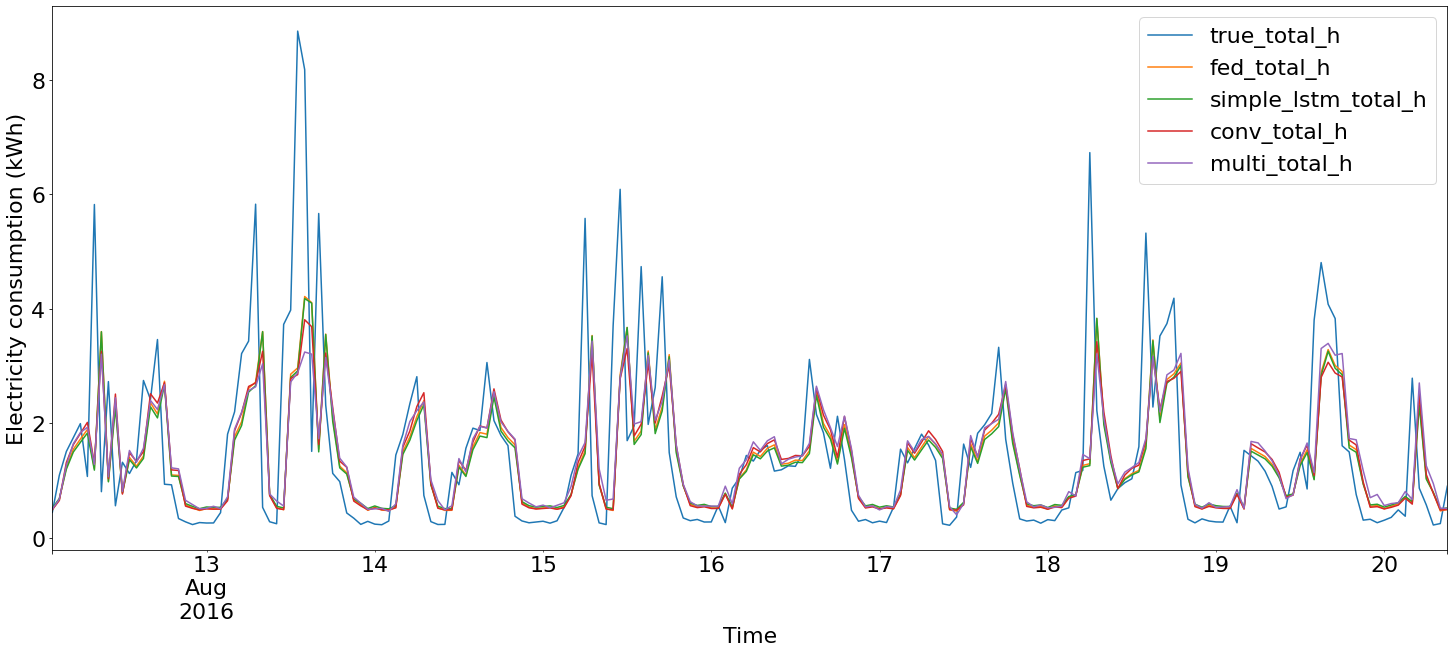

In [507]:
preds_h.iloc[100:300,:].plot(ylabel='Electricity consumption (kWh)', xlabel="Time", figsize=(25,10))

In [309]:
# pd.Series(multi_rmse_test).to_frame().to_csv("multirmse.csv")
# pd.Series(multi_mape_test).to_frame().to_csv("multi_mape.csv")
# pd.Series(mape_test).to_frame().to_csv("mape_smart.csv")

In [509]:
#Store the results
predictions.to_csv("pred_smart.csv")

In [513]:
multi_preds= pd.DataFrame.from_dict(multi_test, orient='index').T

In [514]:
multi_preds.to_csv("multi_preds_smart.csv")